In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy import stats
import seaborn as sns
from functools import reduce
pd.options.mode.chained_assignment = None 
from statistics import mean
from Profile_Generation import *
from plotting import *
from analysis import *
import warnings
warnings.simplefilter('ignore', np.RankWarning)
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from openpyxl import load_workbook
import math
from scipy.optimize import OptimizeWarning
warnings.simplefilter("ignore", OptimizeWarning)
import timeit
from sklearn.metrics import mean_squared_error

In [ ]:
%%time
# ~18mins

# Execute CURATE without pop tau
execute_CURATE()

In [ ]:
%%time
# Perform CV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_CV()
execute_CURATE_and_update_pop_tau_results('CV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

# Perform LOOCV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_LOOCV()
execute_CURATE_and_update_pop_tau_results('LOOCV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

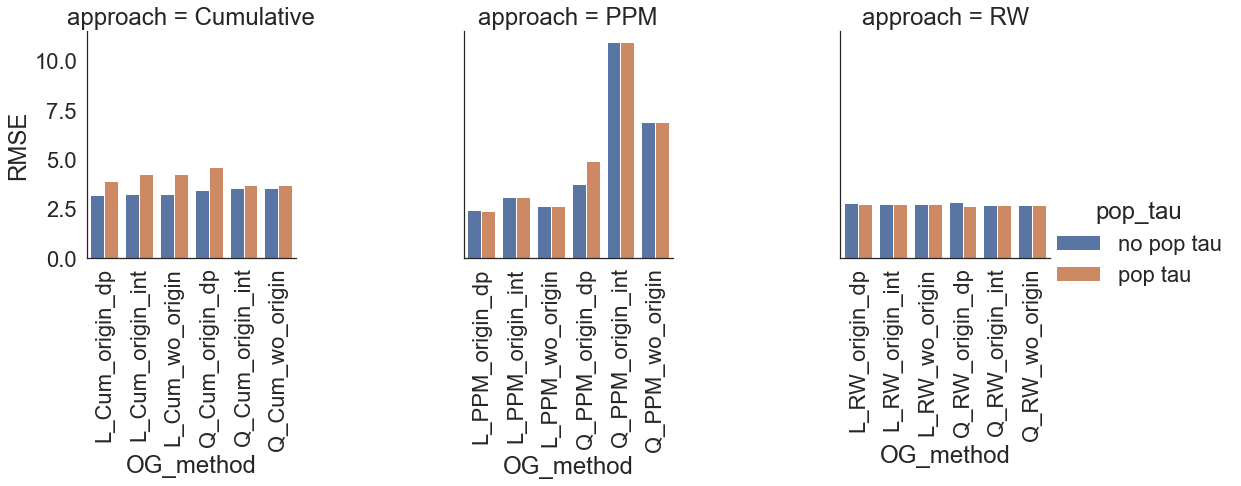

In [201]:
df = RMSE_plot()

<Figure size 432x576 with 0 Axes>

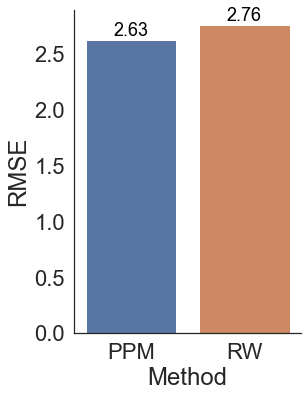